In [1]:
from pickle import load
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
PATH = './data'

# read data
with open(os.path.join(PATH, 'beta.pickle'), 'rb') as f:
    beta_list = np.array(load(f))
with open(os.path.join(PATH, 'freeenergy.pickle'), 'rb') as f:
    freeenergy_list = np.array(load(f))

mean_freeenergy = []
for data in freeenergy_list:
    mean_freeenergy.append(data.mean())
mean_freeenergy = np.array(mean_freeenergy)

In [3]:
from scipy import integrate
def exactFreeEnergy(beta=0.2):
    K = beta
    L = beta
    k = 1.0/(np.sinh(2*K)*np.sinh(2*L))
    result = -1.0/beta*(np.log(2)/2+1.0/(2*np.pi)*integrate.quad(lambda x: np.log(np.cosh(2*K)*np.cosh(2*L)+1/k*np.sqrt(1+k**2-2*k*np.cos(2*x))), 0, np.pi)[0])
    return result

exact_freeenergy = []
for beta in beta_list:
    exact_freeenergy.append(exactFreeEnergy(beta))
exact_freeenergy = np.array(exact_freeenergy)

In [4]:
from scipy.integrate import quad

with open(os.path.join(PATH, 'S_list.pickle'), 'rb') as f:
    S_list = np.array(load(f))

with open(os.path.join(PATH, 'log_prob_list.pickle'), 'rb') as f:
    log_prob_list = np.array(load(f))

def onsager_free_energy_density(T, J=1):
    k_B = 1.0
    K = J / (k_B * T)
    k = 2 * np.sinh(2 * K) / np.cosh(2 * K)**2
    
    # 被积函数
    def integrand(theta):
        return np.log(0.5 * (1 + np.sqrt(1 - k**2 * np.sin(theta)**2)))
    
    integral, error = quad(integrand, 0, np.pi)
    free_energy_density = -k_B * T * np.log(2 * np.cosh(2 * K)) - (k_B * T / (2 * np.pi)) * integral
    
    return free_energy_density

def onsager_entropy_density(T, J=1):
    k_B = 1.0
    
    # 数值计算熵密度
    dF_dT = np.gradient([onsager_free_energy_density(Ti, J) for Ti in T], T)
    entropy_density = -dF_dT / k_B
    
    return entropy_density

# 定义温度范围
T = 1.0/beta_list
# 计算熵密度
entropy_density = onsager_entropy_density(T)


n, m, k, L, L = S_list.shape
exp_values = -log_prob_list

result = np.sum(exp_values, axis=(1)) / (L*L*m*k) #这里求和的范围有改变，需要审视

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#-------------------- 配置Matplotlib参数以接近期刊风格 --------------------

# 使用LaTeX字体渲染，以接近期刊排版样式
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=14)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')

# 设置线条参数
mpl.rc('lines', linewidth=2, markeredgewidth=1)

# 坐标轴的细节设置
mpl.rc('axes', labelsize=16, titlesize=16, linewidth=1.5)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# 坐标刻度向内（更接近APS风格）
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')

# 去掉图例边框
mpl.rc('legend', frameon=False)

/tmp/ipykernel_14414/1096843365.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


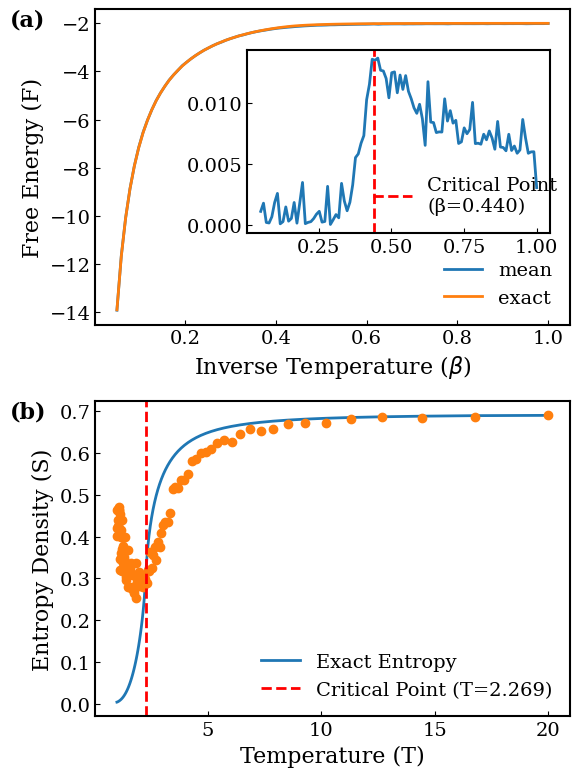

In [36]:
fig, ax = plt.subplots(2, figsize=(6, 8))

#-------------------- 绘图1 --------------------

start = 0
out = np.abs(np.array(mean_freeenergy[start:])-np.array(exact_freeenergy[start:])).mean()

ax[0].plot(beta_list[start:], mean_freeenergy[start:], label='mean')
ax[0].plot(beta_list[start:], exact_freeenergy[start:], label="exact")


# 添加横纵坐标标签
ax[0].set_xlabel(r'Inverse Temperature ($\beta$)')  # 横坐标为 β
ax[0].set_ylabel('Free Energy (F)')   # 纵坐标为 Free Energy

ax[0].legend()

inset_ax = inset_axes(ax[0], width="160%", height="145%", loc='lower right', 
                      bbox_to_anchor=(0.58, 0.26, 0.4, 0.4),
                      bbox_transform=ax[0].transAxes)

relative_error = np.abs(mean_freeenergy - exact_freeenergy) / np.abs(exact_freeenergy)
start = 0
out = (mean_freeenergy[start:] - exact_freeenergy[start:]).mean()

inset_ax.plot(beta_list[start:], relative_error[start:])

#inset_ax.set_title("Relative Error")

# 添加一条位于 β=0.4407 的竖线
inset_ax.axvline(x=0.4407, color='r', linestyle='--', label="Critical Point \n(β=0.440)")
inset_ax.legend(loc='lower right', bbox_to_anchor=(1.1, 0.0))

ax[0].text(-0.18, 1.00, '(a)', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
#-------------------- 绘图2 --------------------
ax[1].plot(T, entropy_density, label="Exact Entropy")
ax[1].set_xlabel('Temperature (T)')
ax[1].set_ylabel('Entropy Density (S)')

ax[1].plot(1/beta_list, result, marker='o', linestyle='None')

# 添加一条位于 β=0.4407 的竖线
ax[1].axvline(x=2.26911, color='r', linestyle='--', label="Critical Point (T=2.269)")
ax[1].legend(fontsize=14)

ax[1].text(-0.18, 1.00, '(b)', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.tight_layout()

plt.savefig("./fig2.pdf", dpi=600) 
fig.show()
